In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import label

from helpers import ChainablePlt

# Summary of *Spatiotemporal Cluster Analysis of Gridded Temperature Data - A Comparison Between K-means and MiSTIC*

Source: https://arxiv.org/abs/2307.00480 \
Authors: E Ankitha Reddy, KS Rajan

## 1 Detailed summary of the paper

### 1.1 Introduction
The Earth's climate is a complex and constantly changing system, as highlighted in the paper's introduction (Section I). It influences life on global and local levels, making it crucial to understand how it evolves over space and time. Analyzing this requires clustering methods that can handle large volumes of climate data, simplifying them into meaningful patterns. The authors introduce two clustering techniques, K-means and MiSTIC, applied to temperature datasets for the Indian subcontinent. These datasets include daily temperature data from the Indian Meteorological Department (IMD) and the HadCM3 global climate model (Abstract, Section I).

### 1.2 Data Used 
 
The study uses two temperature datasets. The IMD dataset, spanning 1969–2005, provides high-resolution daily temperature data for the Indian subcontinent. It is formatted into a 1°x1° grid based on observations from 395 stations. The HadCM3 dataset, covering 1989–2019, is a global climate model that also includes temperature data but requires resampling to match IMD’s grid resolution. Both datasets are divided into spatial grids, allowing for consistent analysis across methods. In this proof-of-concept, mock data is generated to mimic the gridded datasets.(Abstract, Section II.A).

| Dataset     | Time Period  | Resolution   | Temperature Unit | Coverage       |
|-------------|--------------|--------------|------------------|----------------|
| IMD         | 1969–2005    | 1°x1°        | Celsius          | Indian region  |
| HadCM3      | 1989–2019    | 1°x1° (resampled) | Kelvin           | Global         |

**Where in the code**: The creation of mock datasets with latitude, longitude, and temperature variables is detailed below in  _2.1: Generate Mock Temperature Data_.

### 1.3 Clustering Methods

K-means groups data based on proximity in feature space. Users must specify the number of clusters beforehand, and the algorithm iteratively assigns data points to clusters based on their distance to cluster centroids. This method is straightforward and computationally efficient but does not account for temporal changes.

MiSTIC takes a different approach by identifying "core areas" that show consistent behavior over time. It uses neighborhood analysis to group nearby points and frequent itemset mining to find patterns that recur across years. MiSTIC is more dynamic than K-means but depends heavily on data quality and completeness (Sections II.B.1 and II.B.2).  

**Where in the code**: K-means clustering is implemented in _2.2 Apply K-means Clustering_, while a simplified MiSTIC algorithm is coded in _2.3 Simplified MiSTIC Clustering_.

### 1.4 Results
The results of applying these methods are presented in Section III. For IMD data, K-means identified key regions like the Himalayas, the Indo-Gangetic plains, the Deccan Plateau, and the coastal areas. MiSTIC found similar regions but focused on areas with recurring patterns over time, such as river basins and semi-arid regions. The HadCM3 data showed differences in clustering because of its global coverage and different resolution compared to IMD. For example, MiSTIC’s clustering of the Himalayan region varied between the two datasets, illustrating how data quality and source affect the outcomes. The authors note that MiSTIC produced more refined clusters for regions with high data density, whereas K-means performed consistently but more broadly (Section III, Figures 1–3).

**Where in the code**: Visualization of K-means clusters is in _2.2 Apply K-means Clustering_, while MiSTIC results are visualized in _2.3 Simplified MiSTIC Clustering_.

### 1.5 Elevation and Slope Trends
In Section III, the authors also analyzed how elevation and slope influenced clusters. K-means clusters for IMD data showed a wide range of elevations, often below 1500 meters. For HadCM3, the trends were slightly different, with fewer clusters above 2000 meters. MiSTIC clusters, by comparison, were more tightly grouped, suggesting that it captures physical terrain characteristics better than K-means. This analysis shows that MiSTIC can detect finer topographical patterns, while K-means provides a more general overview (Section III, Figures 4 and 5).

**Where in the code**: While elevation and slope are not explicitly included in this proof-of-concept, _2.3 Simplified MiSTIC Clustering_ highlights how spatial features influence core detection.

### 1.6 Insights and Challenges  
Section IV discusses key insights and challenges. The study highlights the importance of data quality, as seen in the differences between IMD and HadCM3 clustering results. MiSTIC’s clusters in the Himalayan region differed due to varying levels of data detail and coverage. Another challenge with MiSTIC is that it depends on continuous and dense data to fully capture spatiotemporal patterns, making it less effective in regions with sparse or incomplete data. In contrast, K-means is simpler and performs reliably without such dependencies, but it lacks the ability to capture temporal dynamics (Sections III, IV).

**Comparison Table: Strengths and Weaknesses**  

| Method    | Strengths                           | Weaknesses                          |
|-----------|-------------------------------------|-------------------------------------|
| K-means   | Simple, computationally efficient   | Ignores temporal and neighborhood data |
| MiSTIC    | Captures spatiotemporal patterns    | Sensitive to data gaps, computationally intensive |

**Where in the code**: The challenges and differences between the methods are discussed in _2.4 Compare Clustering Methods_.

### 1.7 Conclusion
The authors conclude that both methods have strengths and limitations (Section IV). K-means is easy to use and provides clear spatial divisions but ignores changes over time and relationships between regions. MiSTIC is better for analyzing how patterns evolve over years but requires high-quality data and is computationally more demanding. The study emphasizes the need for improved data availability and resolution, especially in areas with sparse observations, to enhance the effectiveness of both techniques (Section IV).  

This paper serves as a foundation for applying spatiotemporal clustering techniques to climate data, offering insights into their potential applications and challenges (Abstract, Section IV).

**Where in the code**: The conclusion is supported by the final comparison in _2.4 Compare Clustering Methods_, which overlays K-means and MiSTIC results.

## 2 Proof of concept: K-means and Simplified MiSTIC Clustering

### 2.1 Generate Mock Temperature Data

In [2]:
np.random.seed(42)

def generate_mock_temperature_data(num_points=100):
    """Generate mock gridded temperature data with latitudes, longitudes, and temperatures."""
    latitude = np.random.uniform(10, 35, num_points)  # Simulated latitudes (Indian region)
    longitude = np.random.uniform(70, 90, num_points)  # Simulated longitudes (Indian region)
    temp_max = np.random.uniform(25, 45, num_points)  # Max temperature (°C)
    temp_min = np.random.uniform(5, 25, num_points)  # Min temperature (°C)

    # Combine into a DataFrame
    data = pd.DataFrame({
         "Latitude": latitude, 
         "Longitude": longitude, 
         "Max_Temp": temp_max, 
         "Min_Temp": temp_min
        })
    
    return data

# Simulate grid data for temperatures (100 grid points)
data = generate_mock_temperature_data()

In [3]:
# Display a preview of the generated data
data.head()

,Latitude,Longitude,Max_Temp,Min_Temp
0,19.363503,70.628584,37.840633,6.033634
1,33.767858,82.728208,26.682799,15.627093
2,28.299849,76.287120,28.232574,15.812702
3,24.966462,80.171414,42.971084,17.748598
4,13.900466,88.151329,37.128581,19.521827


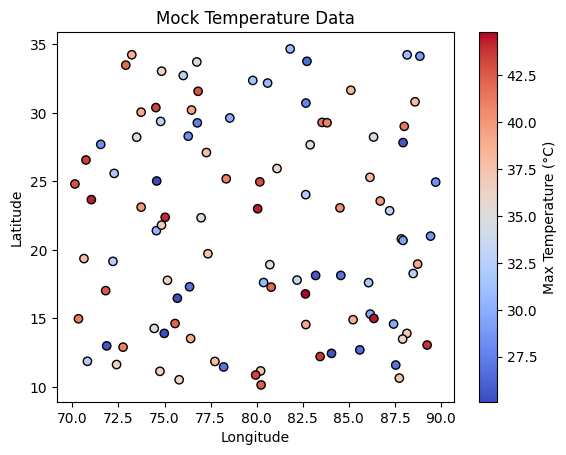

In [4]:
# Visualize the mock data spatially
cplt = ChainablePlt(plt)
cplt.scatter(data['Longitude'], data['Latitude'], c=data['Max_Temp'], cmap='coolwarm', edgecolor='k')
cplt.colorbar(label='Max Temperature (°C)')
cplt.txylabel('Mock Temperature Data', 'Longitude', 'Latitude').show()

### 2.2 Apply K-means Clustering

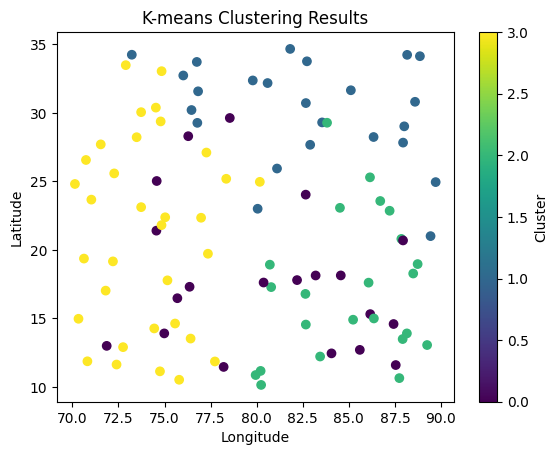

In [5]:
# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Latitude', 'Longitude', 'Max_Temp', 'Min_Temp']])

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize clusters
cplt.scatter(data['Longitude'], data['Latitude'], c=data['KMeans_Cluster'], cmap='viridis')
cplt.colorbar(label='Cluster')
cplt.txylabel('K-means Clustering Results', 'Longitude', 'Latitude').show()

### 2.3 Simplified MiSTIC Clustering

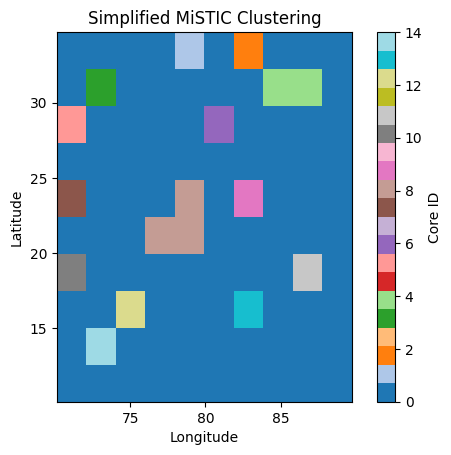

In [6]:
# Define core detection based on frequent high temperatures
threshold = 40  # Threshold for max temperature as core
data['Core_Area'] = (data['Max_Temp'] > threshold).astype(int)


# Define grid resolution and shape
grid_shape = (10, 10)  # Assume a 10x10 grid
lat_min, lat_max = data['Latitude'].min(), data['Latitude'].max()
lon_min, lon_max = data['Longitude'].min(), data['Longitude'].max()

# Normalize latitude and longitude to grid indices
lat_indices = ((data['Latitude'] - lat_min) / (lat_max - lat_min) * (grid_shape[0] - 1)).astype(int)
lon_indices = ((data['Longitude'] - lon_min) / (lon_max - lon_min) * (grid_shape[1] - 1)).astype(int)

# Create the grid
mock_grid = np.zeros(grid_shape)

# Assign core area values to the grid
mock_grid[lat_indices, lon_indices] = data['Core_Area'].values

# Label connected regions (simplified MiSTIC core detection)
labeled_cores, num_cores = label(mock_grid)

# Visualize MiSTIC-like clusters
cplt.imshow(labeled_cores, cmap='tab20', extent=(lon_min, lon_max, lat_min, lat_max))
cplt.colorbar(label='Core ID')
cplt.txylabel('Simplified MiSTIC Clustering', 'Longitude', 'Latitude').show()

In [7]:
print(f"Number of detected cores: {num_cores}")

Number of detected cores: 14


### 2.4 Compare Clustering Methods

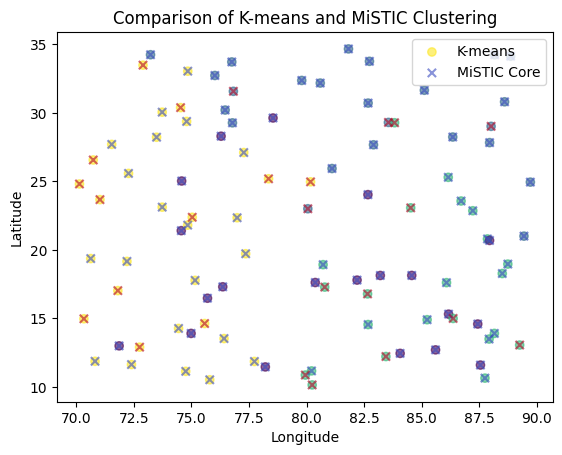

In [8]:
# Overlay K-means and MiSTIC results
cplt.scatter(data['Longitude'], data['Latitude'], c=data['KMeans_Cluster'], cmap='viridis', alpha=0.6, label='K-means')
cplt.scatter(data['Longitude'], data['Latitude'], c=data['Core_Area'], cmap='coolwarm', alpha=0.6, marker='x', label='MiSTIC Core')
cplt.legend()
cplt.txylabel('Comparison of K-means and MiSTIC Clustering', 'Longitude', 'Latitude').show()